In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss

In [6]:
# methods and stuff

def generator(X, y, batch_size, window_size, threashold=0.5):

    while True:

        batch_features = np.zeros((batch_size, window_size, 1))
        batch_velocity = np.zeros((batch_size, window_size, 1))
        batch_labels = np.zeros((batch_size, 2))

        i = 0
        while i < batch_size:
            index = np.random.randint(0, X.shape[0] - window_size)
            val = y[1, index:index + window_size]
            ripple_overlap = np.sum(val) / val.shape[0]
            if ripple_overlap > threashold:
                a = X[index:index + window_size]
                batch_features[i] = np.reshape(a, (a.shape[0], -1))
                if y[0, index:index + window_size].sum() == 0:
                    batch_labels[i] = np.array([1, 0])
                else:
                    batch_labels[i] = np.array([0, 1])
                i += 1
            else:
                pass

        yield batch_features, batch_labels
        
def decode(value, threshold=0.992):
    mask = value[:, 1] > threshold
    y_pred_int = np.array(mask, dtype=int)
    return y_pred_int


In [4]:
df = pd.read_pickle('data/processed/data.pkl')

In [5]:
df

,time,LFP,fLFP,eLFP,speed,ripple_true,ripple_cand
0,0.0000,0.299396,-0.000121,0.005443,0.000000,0.0,0.0
1,0.0004,0.308412,-0.002539,0.003556,0.000000,0.0,0.0
2,0.0008,0.308734,-0.004188,0.005346,0.000000,0.0,0.0
3,0.0012,0.287482,-0.004424,0.006828,0.000000,0.0,0.0
4,0.0016,0.286516,-0.002978,0.007932,0.034558,0.0,0.0
...,...,...,...,...,...,...,...
1507790,603.1160,-0.085708,-0.018181,0.025413,6.462256,0.0,0.0
1507791,603.1164,-0.061558,-0.022800,0.023889,6.496814,0.0,0.0
1507792,603.1168,-0.060592,-0.021257,0.021550,6.496814,0.0,0.0
1507793,603.1172,-0.043849,-0.014264,0.018336,6.462256,0.0,0.0


In [ ]:
# TODO: define smoothed envelope as feature

In [126]:
# define training and validation data
X = []
Y = []
fs = 2500 # Hz
nsteps = 1250 # 
boxcar_width = 0.05 # s
boxcar_full = ss.lfilter(np.ones(int(fs * boxcar_width)), 1, df['ripple_true'])
for tstep in np.where(df['ripple_cand'] == 1)[0]:
    inds = np.arange(- nsteps // 2, nsteps // 2) + tstep
    X += [np.c_[[df['LFP'][inds] - df['LFP'][inds].mean(), df['fLFP'][inds], df['eLFP'][inds]]].T]
    Y += [boxcar_full[inds + int(fs * boxcar_width / 2)]]
X = np.array(X)
Y = np.array(Y)
Y[Y >= 1] = 1.
Y = np.expand_dims(Y, axis=-1)

In [127]:
X.shape, Y.shape

((418, 1250, 3), (418, 1250, 1))

<IPython.core.display.Javascript object>


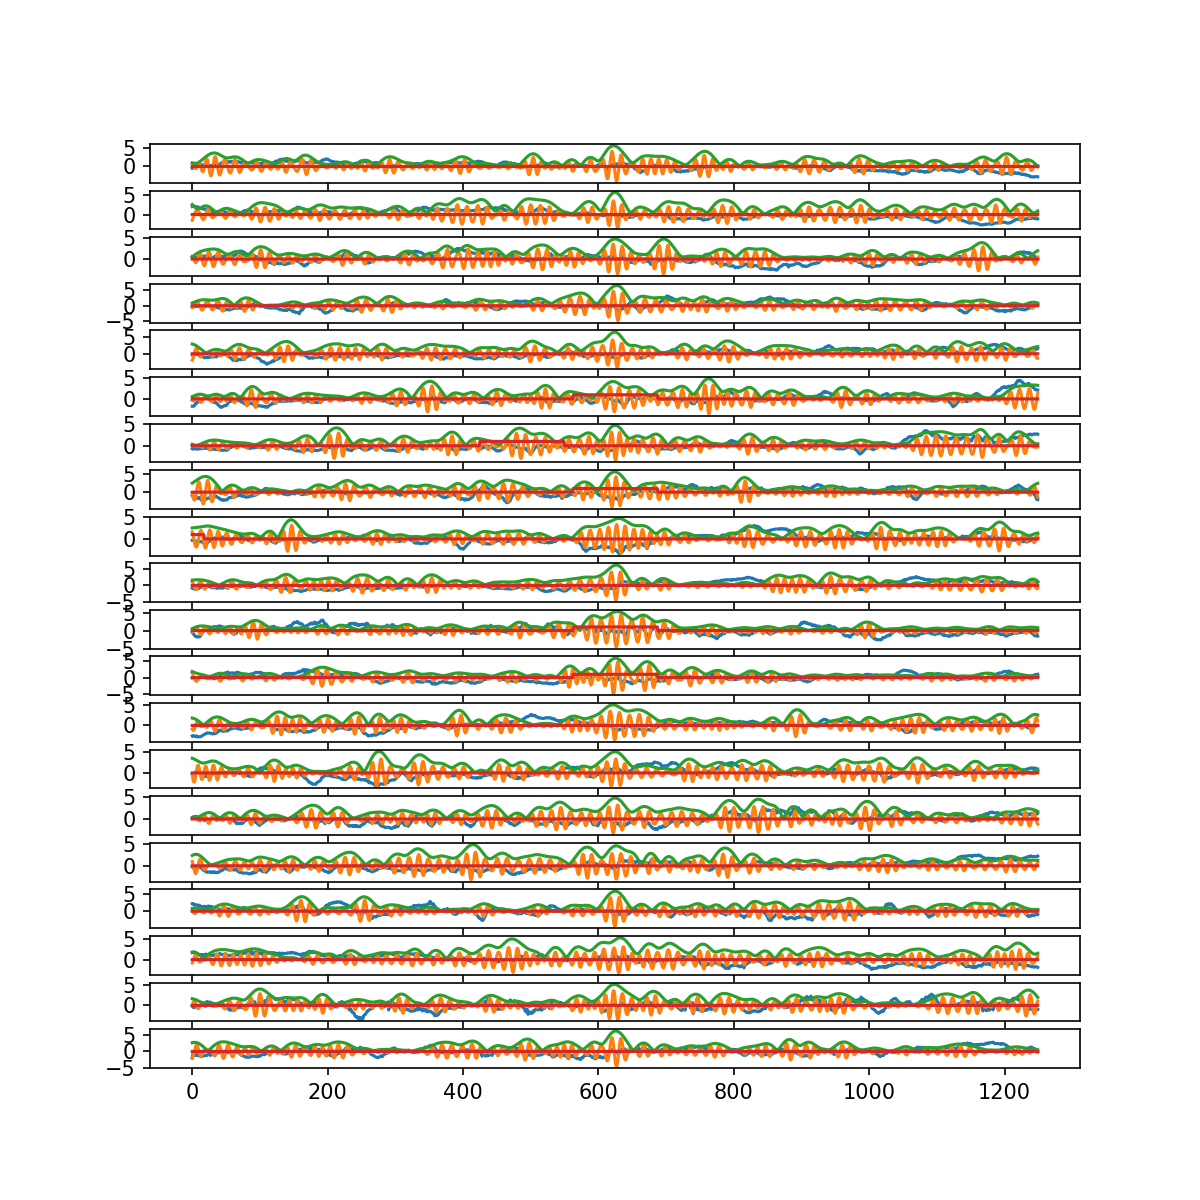

In [128]:
fig, axes = plt.subplots(20, 1, figsize=(8, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(X[i] / X[i].std(axis=0))
    ax.plot(Y[i])
    ax.axis(ax.axis('tight'))

In [129]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization

In [217]:
def generate_model_LSTM(input_shape):
    keras.backend.clear_session()

    print(input_shape)
    
    inputs = keras.layers.Input(shape=input_shape)
    
    #x = keras.layers.Conv1D(20, kernel_size=5, strides=3, activation='relu')(inputs)
    #x = keras.layers.LSTM(20, activation='relu', return_sequences=True)(x)
    x = keras.layers.LSTM(20, activation='relu', return_sequences=True)(inputs)
    #x = keras.layers.GaussianNoise(1.5)(x)
    x = keras.layers.LSTM(20, activation='sigmoid', return_sequences=True)(x)
    
    predictions = keras.layers.TimeDistributed(Dense(1, activation = "sigmoid"))(x) # time distributed  (sigmoid)
    
    model = keras.models.Model(inputs=inputs, outputs=predictions)
    opt = keras.optimizers.Adam(lr=0.0001, beta'_1=0.9, beta_2=0.999, decay=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
           #model.compile(loss=['categorical_crossentropy'],
    #              optimizer=keras.optimizers.Adam(lr=0.01),
    #              metrics=['accuracy'],
    #              # sample_weight_mode='temporal',
    #              )

    return model

SyntaxError: EOL while scanning string literal (<ipython-input-217-7062b4d45e5b>, line 17)

In [218]:
model = generate_model_LSTM(input_shape=X[0].shape)

(1250, 3)


In [214]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1250, 3)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1250, 20)          1920      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1250, 20)          3280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1250, 1)           21        
Total params: 5,221
Trainable params: 5,221
Non-trainable params: 0
_________________________________________________________________


In [215]:
X.shape, Y.shape

((418, 1250, 3), (418, 1250, 1))

In [216]:
model.fit(X, Y)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.